In [1]:
import json
import torch
from pathlib import Path
from types import SimpleNamespace

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from train_model import ConfigurableCNN, set_seed
from simple_dataloader import create_dataloader


In [2]:

with open('exps/1d_simple_test_overfit_2/config.json', 'r') as f:
    cfg = json.load(f)
# Set random seeds for reproducibility
cfg = SimpleNamespace(**cfg)


In [3]:
data_path = Path('data/ben_bucket')
pcaps = data_path.glob('**/*.pcap')
pcap_paths = pd.Series(pcaps)

def extract_pcap_info(path):
    p = Path(path)
    parts = p.parts
    location = parts[3]  # 4th part (traffic/location/date...)
    date_str = parts[4]  # 5th part is the date
    app = parts[5]       # 6th part is the app
    vpn_type = parts[6]   # 7th part is VPN/Non-VPN

    date = pd.to_datetime(date_str, format='%Y%m%d_%H%M%S')
    
    return location, date, app, vpn_type

# Apply the function to each path in the series
df = pd.DataFrame(pcap_paths.apply(extract_pcap_info).tolist(), columns=['location', 'date', 'app', 'vpn_type'])

df['pcap_path'] = pcap_paths

# randomly sample
df_huji = df[df.location == 'TLVunContainer1']
df_huji = df_huji.sample(frac=1).reset_index(drop=True).sample(5)

# train-val split
df_huji.sort_values(by='date')
split_index = int(len(df_huji) * 0.7)

# Split the data into train and test based on the temporal order
df_huji_train = df_huji[:split_index]
df_huji_val = df_huji[split_index:]

train_pcap_paths = df_huji_train.pcap_path.astype(str)
train_labels = df_huji_train.app

val_pcap_paths = df_huji_val.pcap_path.astype(str)
val_labels = df_huji_val.app
label_types = np.unique(train_labels)
# Create the dataloader
train_loader = create_dataloader(
    train_pcap_paths, 
    train_labels, 
    batch_size=8, 
    shuffle=True, 
    min_flow_length=100,
    resolution=cfg.RESOLUTION,
    )

100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


In [4]:
set_seed(cfg.SEED)

In [5]:
# Initialize model
cfg.MODEL_PARAMS['num_classes'] = 4
model = ConfigurableCNN(cfg.MODEL_PARAMS).to(cfg.DEVICE)

In [ ]:

# Define checkpoint path (modify as per actual path)
checkpoint_path = Path(cfg.EXPERIMENT_PATH) / 'model_checkpoint.pth'  # replace with specific epoch as needed

# Load checkpoint if it exists
# if checkpoint_path.exists():
#     model.load_state_dict(torch.load(checkpoint_path))
#     print("Checkpoint loaded from:", checkpoint_path)
# else:
#     print("No checkpoint found at:", checkpoint_path)


In [7]:
def register_sequential_hooks(model):
    # Dictionary to store intermediate outputs
    outputs = {}

    # Register hooks for each layer in the sequential container
    for idx, layer in enumerate(model.conv_layers):
        layer.register_forward_hook(lambda layer, inp, outp, idx=idx: outputs.update({f"conv_layer_{idx}": outp}))

    # Register hooks for other layers (pooling and fully connected layers)
    model.pool.register_forward_hook(lambda layer, inp, outp: outputs.update({"pool_output": outp}))
    model.fc1.register_forward_hook(lambda layer, inp, outp: outputs.update({"fc1_output": outp}))
    model.fc2.register_forward_hook(lambda layer, inp, outp: outputs.update({"fc2_output": outp}))

    return outputs


In [8]:
# Get hooks dictionary to hold outputs
intermediate_outputs = register_sequential_hooks(model)

# Create a sample batch (dummy data as example, replace with real batch from dataloader if needed)
input_shape = (cfg.BATCH_SIZE, cfg.MODEL_PARAMS['in_channels'], cfg.MODEL_PARAMS['input_shape'])
flowpics, labels = next(iter(train_loader))

# Forward pass with sample input
model.eval()
with torch.no_grad():
    _ = model(flowpics.to(cfg.DEVICE))  # Forward pass to trigger hooks

# Display intermediate outputs for debugging
for layer_name, output in intermediate_outputs.items():
    print(f"Layer: {layer_name}, Output Shape: {output.shape}")



Layer: conv_layer_0, Output Shape: torch.Size([6, 8, 2048])
Layer: conv_layer_1, Output Shape: torch.Size([6, 8, 2048])
Layer: conv_layer_2, Output Shape: torch.Size([6, 16, 2048])
Layer: conv_layer_3, Output Shape: torch.Size([6, 16, 2048])
Layer: conv_layer_4, Output Shape: torch.Size([6, 32, 2048])
Layer: conv_layer_5, Output Shape: torch.Size([6, 32, 2048])
Layer: conv_layer_6, Output Shape: torch.Size([6, 64, 2048])
Layer: conv_layer_7, Output Shape: torch.Size([6, 64, 2048])
Layer: conv_layer_8, Output Shape: torch.Size([6, 128, 2048])
Layer: conv_layer_9, Output Shape: torch.Size([6, 128, 2048])
Layer: conv_layer_10, Output Shape: torch.Size([6, 1, 2048])
Layer: conv_layer_11, Output Shape: torch.Size([6, 1, 2048])
Layer: pool_output, Output Shape: torch.Size([6, 1, 2048])
Layer: fc1_output, Output Shape: torch.Size([6, 16])
Layer: fc2_output, Output Shape: torch.Size([6, 4])


In [9]:
# Display final model output
with torch.no_grad():
    final_output = model(flowpics.to(cfg.DEVICE))
print("Final Output Shape:", final_output.shape)
print("Final Output (sample):", final_output)


Final Output Shape: torch.Size([6, 4])
Final Output (sample): tensor([[-0.1712,  0.2059, -0.1092, -0.0386],
        [-0.1713,  0.2059, -0.1092, -0.0385],
        [-0.1712,  0.2059, -0.1092, -0.0385],
        [-0.1712,  0.2059, -0.1092, -0.0385],
        [-0.1714,  0.2058, -0.1092, -0.0384],
        [-0.1712,  0.2059, -0.1092, -0.0386]], device='cuda:0')


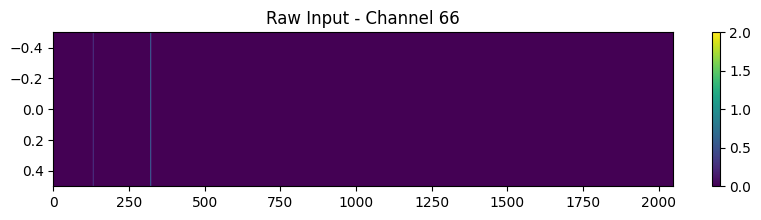

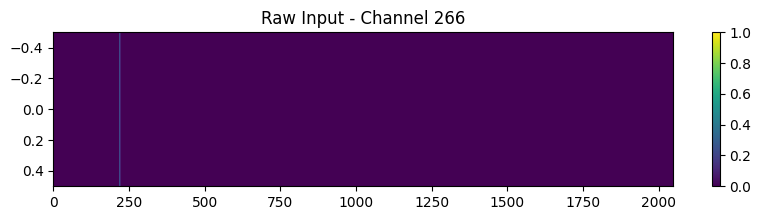

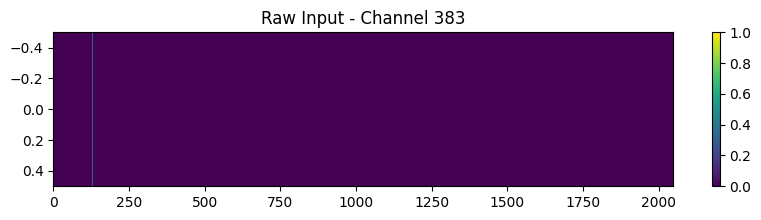

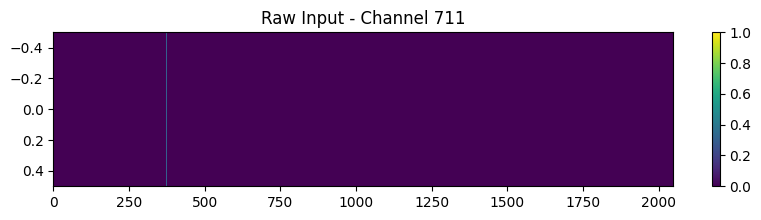

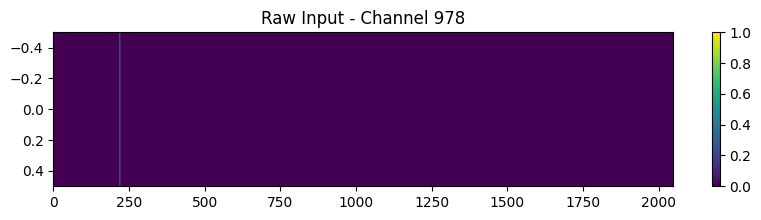

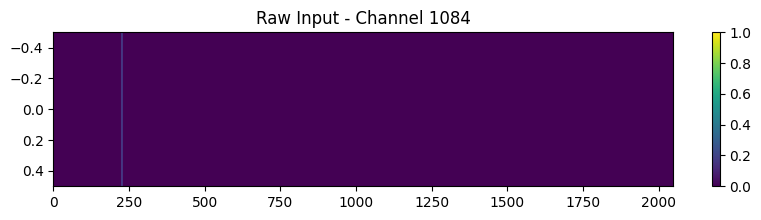

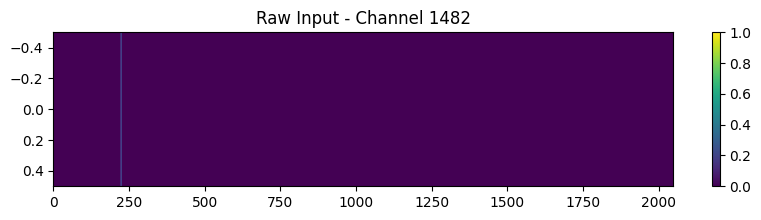

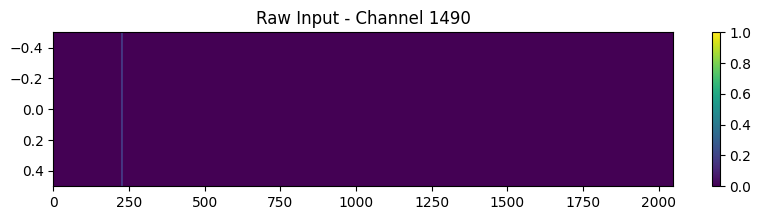

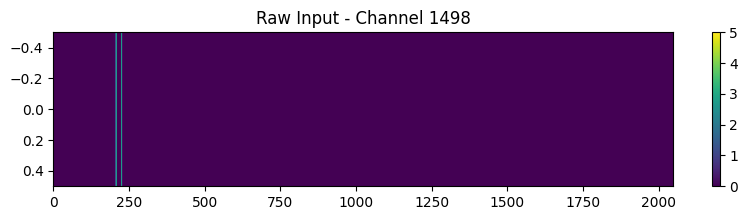

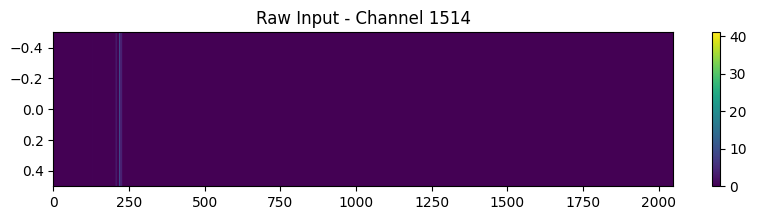

In [21]:
# Create a sample input (dummy data; replace with real data batch as needed)
input_shape = (cfg.BATCH_SIZE, cfg.MODEL_PARAMS['in_channels'], cfg.MODEL_PARAMS['input_shape'])

# Plot raw input
def plot_raw_input(input_data):
    input_data = input_data.cpu().detach().numpy()
    if input_data.ndim == 3:  # For 1D input
        for i in range(min(input_data.shape[1], 2000)):  # Display up to 4 channels
            row = input_data[0, i, :]
            if row.sum() < 1:
                continue
            plt.figure(figsize=(10, 2))
            plt.imshow(row.reshape(1, -1), aspect='auto', cmap='viridis')
            plt.colorbar()
            plt.title(f"Raw Input - Channel {i}")
            plt.show()

# Plot raw input before passing through model
plot_raw_input(flowpics)


Layer: conv_layer_0, Shape: (6, 8, 2048)


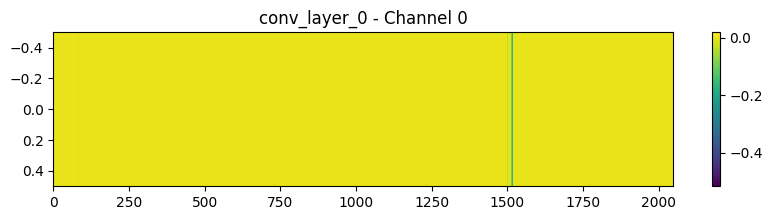

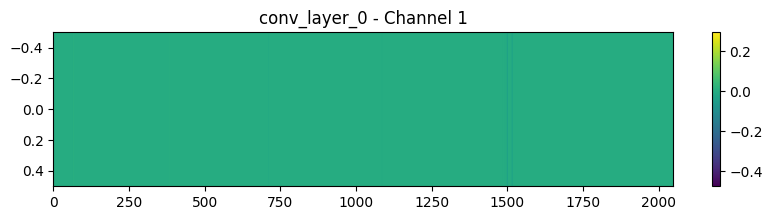

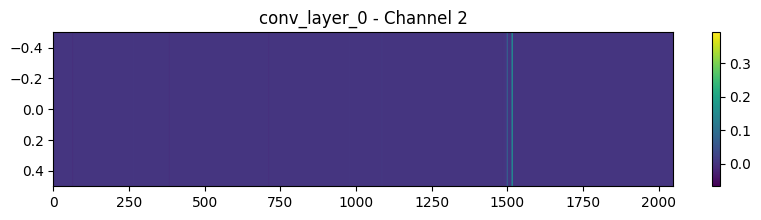

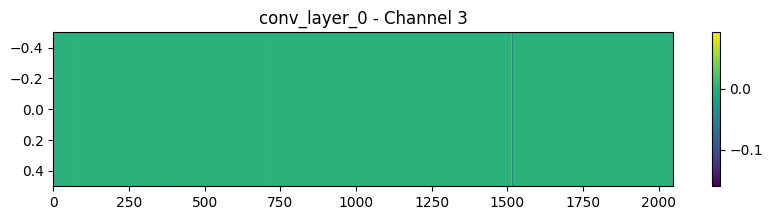

Layer: conv_layer_1, Shape: (6, 8, 2048)


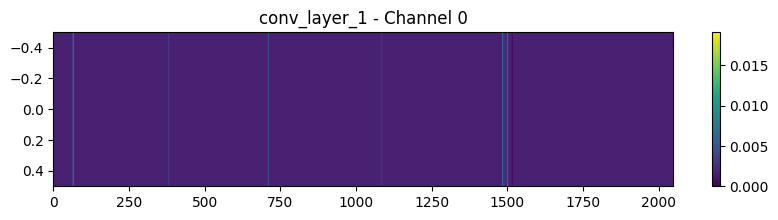

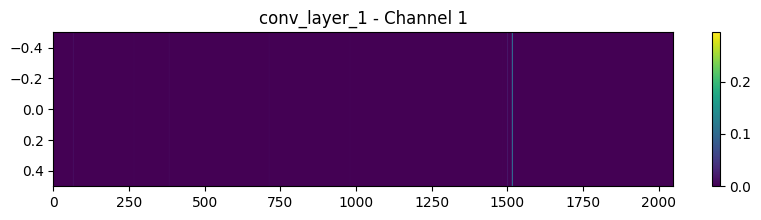

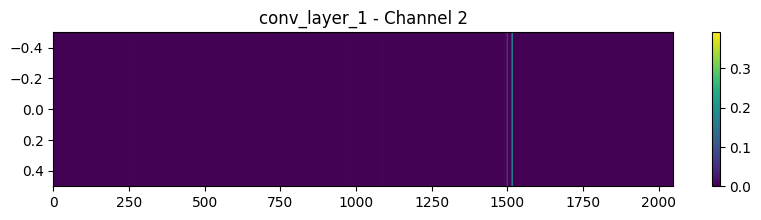

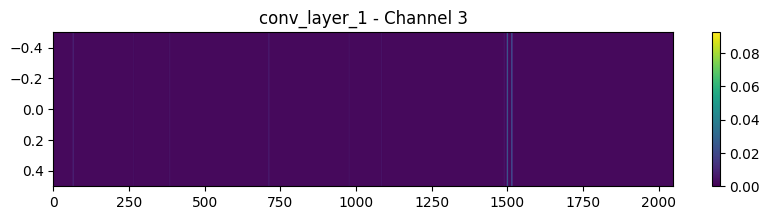

Layer: conv_layer_2, Shape: (6, 16, 2048)


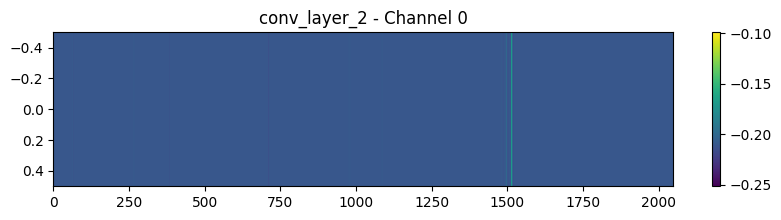

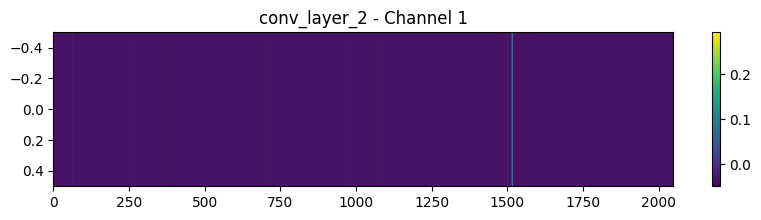

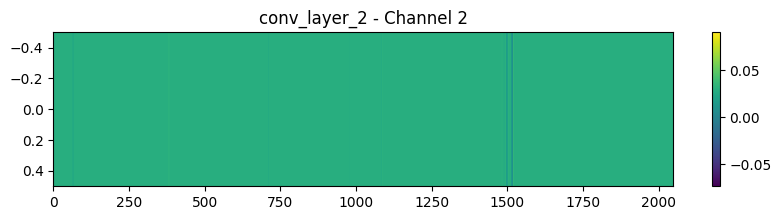

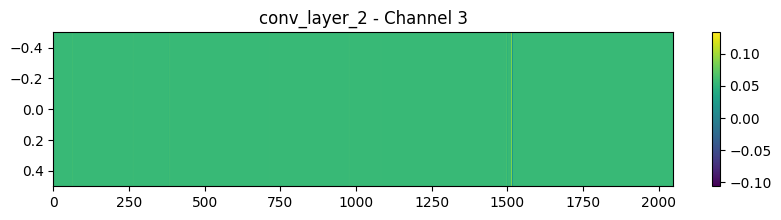

Layer: conv_layer_3, Shape: (6, 16, 2048)


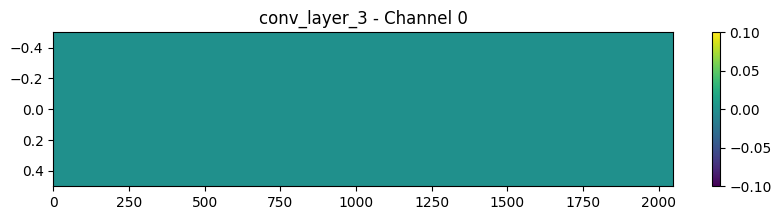

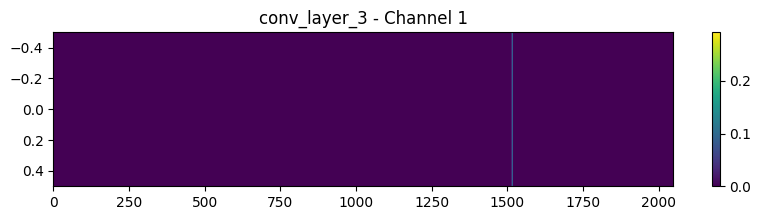

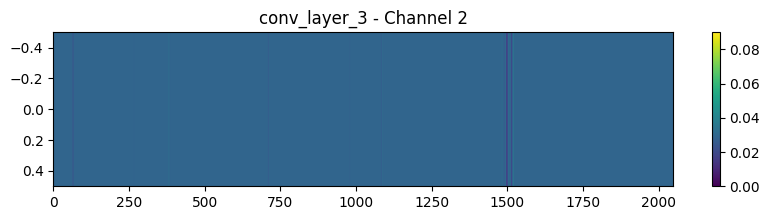

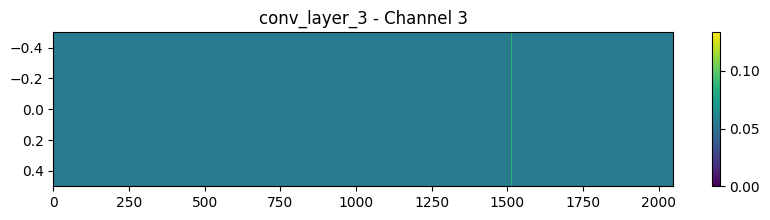

Layer: conv_layer_4, Shape: (6, 32, 2048)


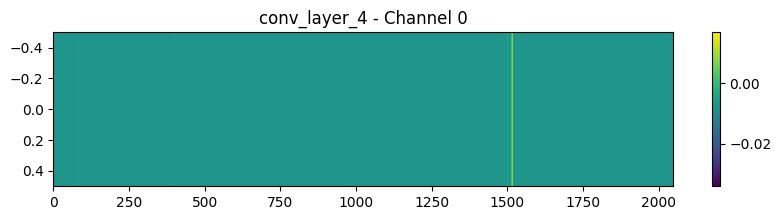

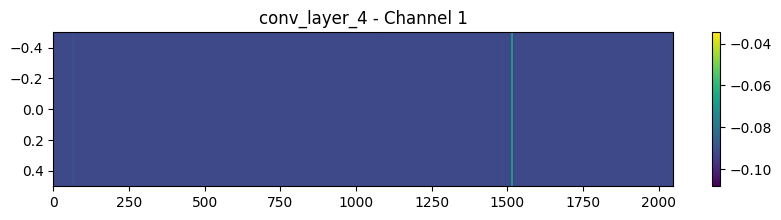

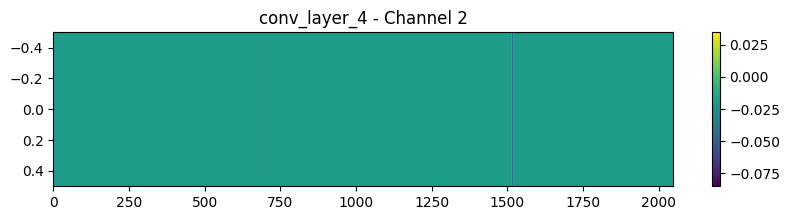

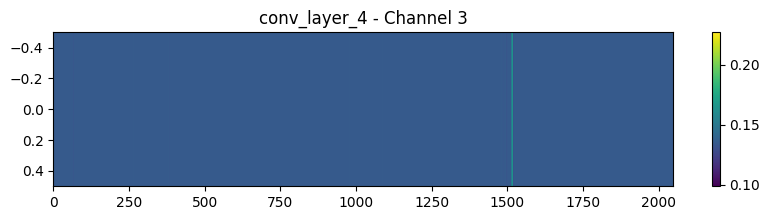

Layer: conv_layer_5, Shape: (6, 32, 2048)


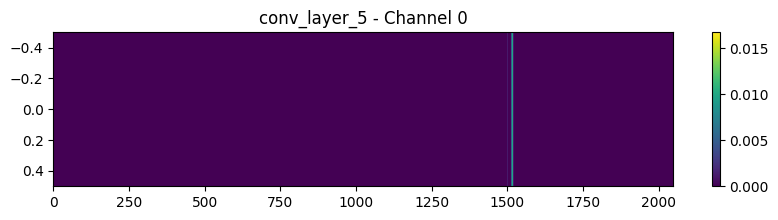

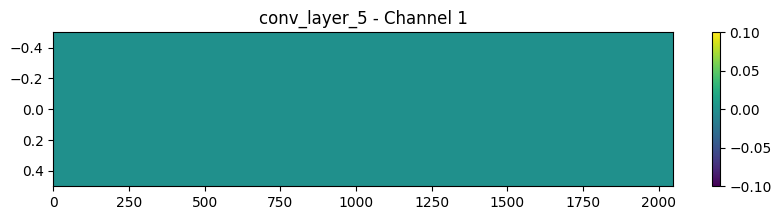

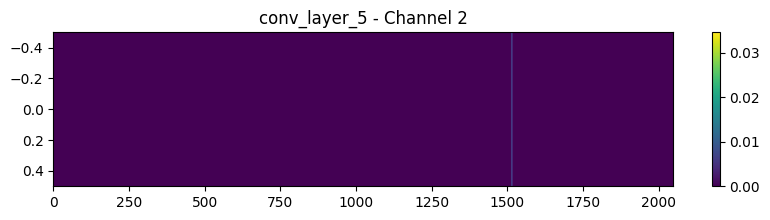

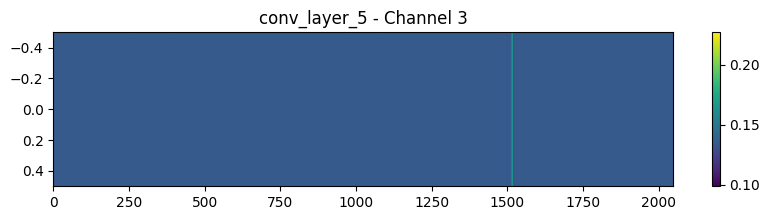

Layer: conv_layer_6, Shape: (6, 64, 2048)


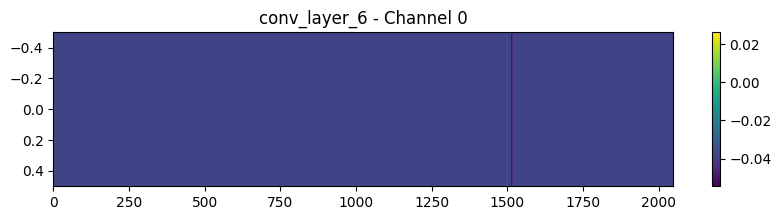

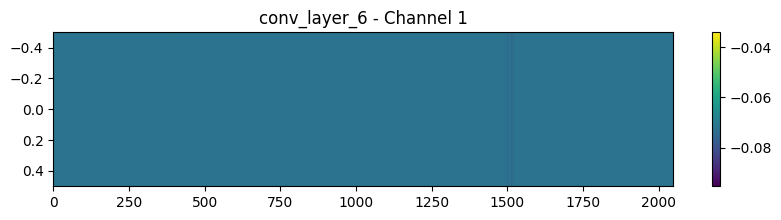

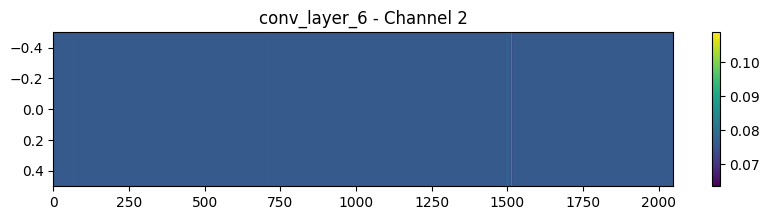

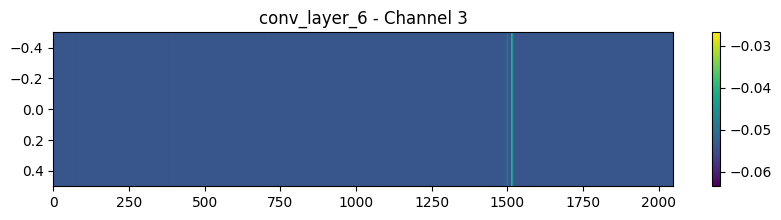

Layer: conv_layer_7, Shape: (6, 64, 2048)


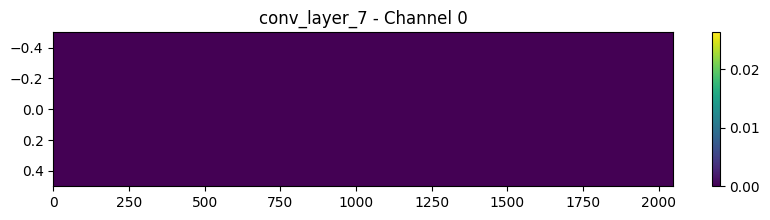

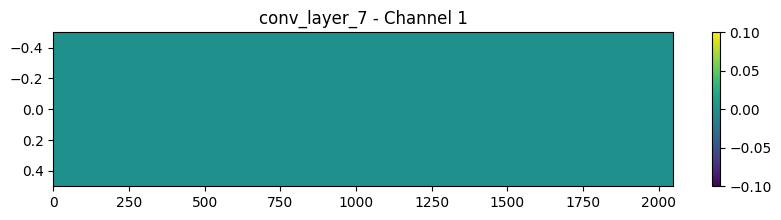

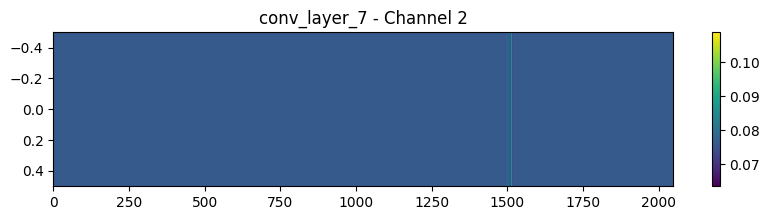

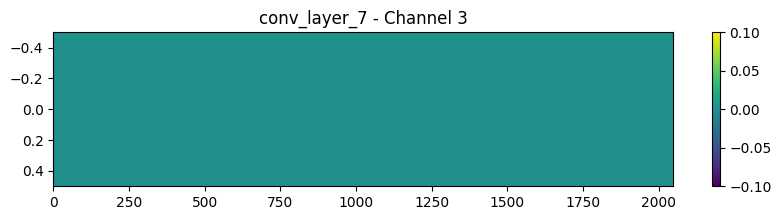

Layer: conv_layer_8, Shape: (6, 128, 2048)


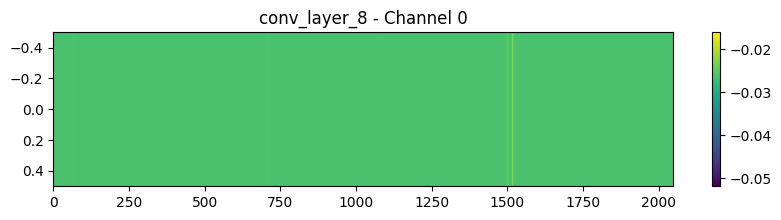

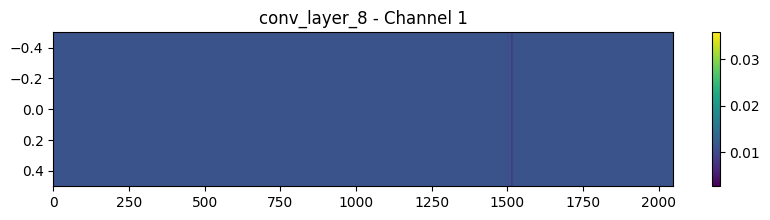

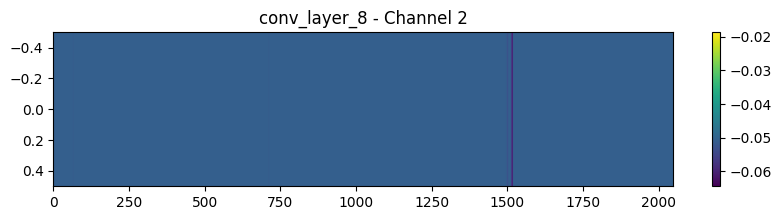

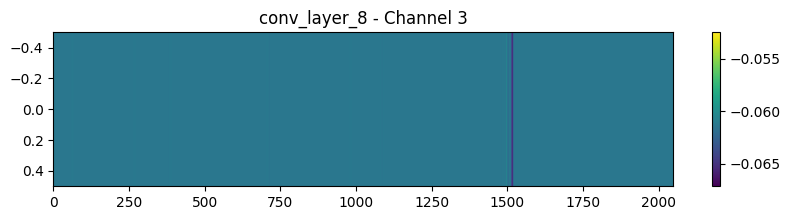

Layer: conv_layer_9, Shape: (6, 128, 2048)


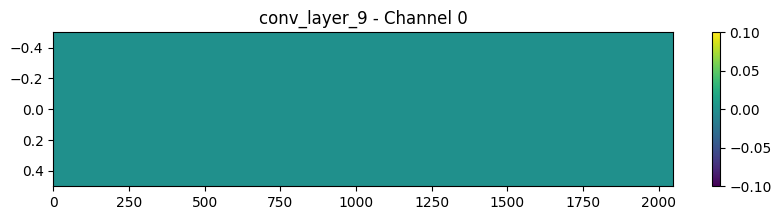

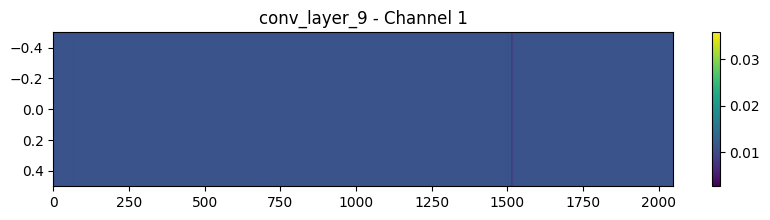

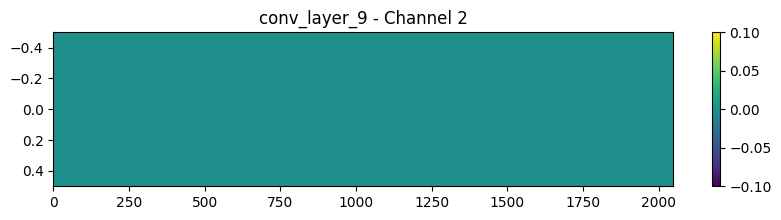

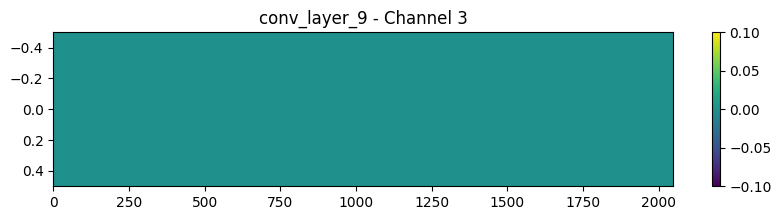

Layer: conv_layer_10, Shape: (6, 1, 2048)


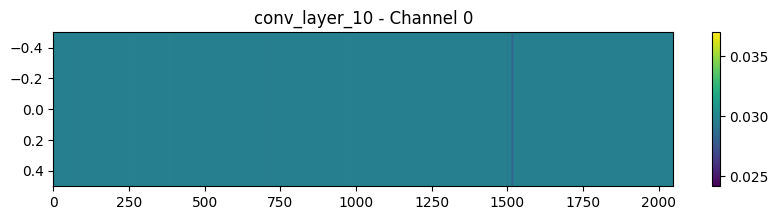

Layer: conv_layer_11, Shape: (6, 1, 2048)


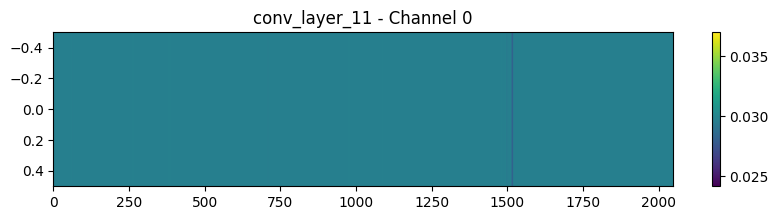

Layer: pool_output, Shape: (6, 1, 2048)


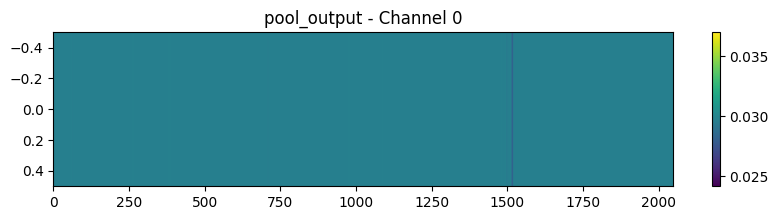

Layer: fc1_output, Shape: (6, 16)


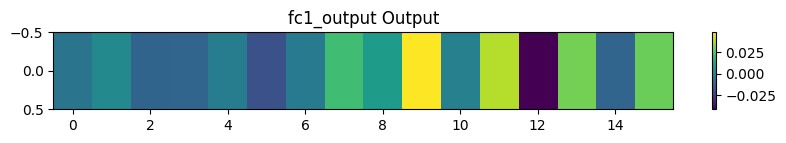

Layer: fc2_output, Shape: (6, 4)


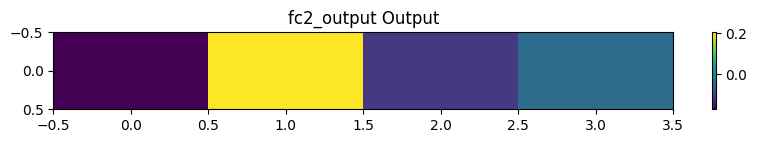

In [11]:
def plot_layer_outputs(outputs):
    for layer_name, output in outputs.items():
        # Convert tensor to CPU and detach for plotting
        output = output.cpu().detach().numpy()
        
        # Plot for 1D convolutional layers
        if output.ndim == 3:  # Shape: (batch, channels, width)
            print(f"Layer: {layer_name}, Shape: {output.shape}")
            for i in range(min(output.shape[1], 4)):  # Limit to 4 channels for readability
                plt.figure(figsize=(10, 2))
                plt.imshow(output[0, i, :].reshape(1, -1), aspect='auto', cmap='viridis')
                plt.colorbar()
                plt.title(f"{layer_name} - Channel {i}")
                plt.show()
        
        # Plot for 2D convolutional layers
        elif output.ndim == 4:  # Shape: (batch, channels, height, width)
            print(f"Layer: {layer_name}, Shape: {output.shape}")
            for i in range(min(output.shape[1], 4)):  # Limit to 4 channels for readability
                plt.figure(figsize=(6, 6))
                plt.imshow(output[0, i, :, :], cmap='viridis')
                plt.colorbar()
                plt.title(f"{layer_name} - Channel {i}")
                plt.show()

        # Plot for fully connected layers
        elif output.ndim == 2:  # Shape: (batch, features)
            print(f"Layer: {layer_name}, Shape: {output.shape}")
            plt.figure(figsize=(10, 1))
            plt.imshow(output[0, :].reshape(1, -1), aspect='auto', cmap='viridis')
            plt.colorbar()
            plt.title(f"{layer_name} Output")
            plt.show()

# Plot intermediate outputs
plot_layer_outputs(intermediate_outputs)
